In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
# Import all baseline correction functions from your package
from epyr.baseline import (
    baseline_polynomial,
    baseline_constant_offset,
    baseline_mono_exponential,
    baseline_stretched_exponential,
    baseline_polynomial_2d
)

Package 'epyr' v0.1.0 initialized.


# Part 1: Functions to Generate Realistic Test Data

This section of the script contains a suite of helper functions dedicated to creating synthetic datasets. The primary goal is to generate data that mimics common real-world scenarios where baseline correction is essential.

Each function is carefully crafted to produce a signal with a known, well-defined baseline, one or more signal peaks, and a layer of random noise. This allows for a robust and clear demonstration of how each baseline correction algorithm in the `epyrtools.baseline` package performs its specific task.

### `generate_poly_1d_data()`

*   **Purpose:** Creates a 1D dataset perfect for testing the `baseline_polynomial` function.
*   **Components:**
    *   **Baseline:** A simple linear slope (`y = mx + c`).
    *   **Signal:** Two distinct Gaussian peaks at different positions and with different widths.
    *   **Noise:** A moderate amount of normally distributed random noise is added to the entire signal.
*   **Returns:** A tuple `(x, y)` containing the 1D coordinate array and the corresponding data array.

### `generate_constant_offset_data()`

*   **Purpose:** Generates the simplest case for baseline correction: a signal shifted vertically by a constant amount. It is designed to test the `baseline_constant_offset` function.
*   **Components:**
    *   **Baseline:** A constant vertical offset (a flat, non-zero line).
    *   **Signal:** A single, broad Gaussian peak.
    *   **Noise:** A small amount of random noise.
*   **Returns:** A single 1D `y` data array. The x-axis is implicitly the array index.

### `generate_exp_1d_data(stretched=False)`

*   **Purpose:** A versatile function that produces a signal with a decaying exponential baseline. It can generate two types of decay, making it suitable for testing both `baseline_mono_exponential` and `baseline_stretched_exponential`.
*   **Parameter:**
    *   `stretched` (bool): If `False` (default), it generates a standard mono-exponential decay (`exp(-t/τ)`). If `True`, it generates a stretched exponential decay (`exp(-(t/τ)^β)`), which is common in complex physical systems.
*   **Components:**
    *   **Baseline:** An exponential decay (either mono or stretched).
    *   **Signal:** A single Gaussian peak located in the middle of the decay.
    *   **Noise:** Random noise is added to the signal.
*   **Returns:** A tuple `(x, y)` containing the 1D coordinate array and the corresponding data array.

### `generate_poly_2d_data()`

*   **Purpose:** Creates a 2D dataset that simulates an image or a spectral map with a non-flat background. This is the ideal test case for the `baseline_polynomial_2d` function.
*   **Components:**
    *   **Baseline:** A 2D "tilted plane" surface, which is a polynomial of order 1 in both the x and y dimensions.
    *   **Signal:** Two distinct 2D Gaussian peaks located at different positions on the surface.
    *   **Noise:** Normally distributed random noise applied to every point on the 2D surface.
*   **Returns:** A tuple `(x, y, Z)` containing the 1D x-axis coordinates, the 1D y-axis coordinates, and the 2D `Z` data matrix.

In [2]:
def generate_poly_1d_data():
    """Generates a 1D signal with two Gaussian peaks on a linear baseline."""
    x = np.linspace(0, 100, 500)
    baseline = 0.15 * x + 5  # Simple sloped baseline
    peak1 = 15 * np.exp(-((x - 35)**2) / 15)
    peak2 = 10 * np.exp(-((x - 75)**2) / 20)
    noise = np.random.normal(0, 0.5, x.shape)
    y = baseline + peak1 + peak2 + noise
    return x, y

def generate_constant_offset_data():
    """Generates a signal with a simple constant vertical offset."""
    x = np.linspace(0, 100, 500)
    baseline_value = 10.0
    signal = 5 * np.exp(-((x - 50)**2) / 40) # A broad peak
    noise = np.random.normal(0, 0.2, x.shape)
    y = baseline_value + signal + noise
    return y

def generate_exp_1d_data(stretched=False,beta=2.2):
    """Generates a 1D signal with a peak on an exponential decay baseline."""
    x = np.linspace(0, 100, 500)
    if stretched:
        # Stretched exponential decay (beta < 1)
        baseline = 20 * np.exp(-(x / 40)**beta) + 2
    else:
        # Mono-exponential decay (beta = 1)
        baseline = 20 * np.exp(-x / 40) + 2
    peak = 12 * np.exp(-((x - 50)**2) / 25)
    noise = np.random.normal(0, 0.3, x.shape)
    y = baseline + peak + noise
    return x, y

def generate_poly_2d_data():
    """Generates a 2D surface with two peaks on a tilted plane."""
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    XX, YY = np.meshgrid(x, y)
    
    # Baseline: a tilted plane surface
    baseline_surface = 0.5 * XX + 0.3 * YY + 10
    
    # 2D signal peaks
    peak1 = 30 * np.exp(-((XX - 3)**2 + (YY + 4)**2) / 8)
    peak2 = 25 * np.exp(-((XX + 5)**2 + (YY - 2)**2) / 10)
    noise = np.random.normal(0, 0.8, XX.shape)
    
    Z = baseline_surface + peak1 + peak2 + noise
    return x, y, Z


# Part 2: Demonstration Functions for Each Algorithm

This section is the core of the demonstration. Each function is a self-contained example designed to showcase the usage and effectiveness of a specific baseline correction algorithm from the `epyrtools.baseline` package.

The workflow for each demonstration is consistent:
1.  **Generate Data:** It calls one of the data generation functions from Part 1 to get a relevant synthetic dataset.
2.  **Define Parameters:** It sets up the necessary parameters for the correction function, such as defining regions to exclude or specifying the model order. This highlights the practical usage of the function's API.
3.  **Execute Correction:** It calls the corresponding baseline correction function with the data and parameters.
4.  **Visualize Results:** It uses `matplotlib` to create a clear and informative plot comparing the original data, the calculated baseline, and the final baseline-corrected data.

### `demo_polynomial_1d()`

*   **Objective:** To demonstrate how to remove a sloped, linear baseline from a 1D signal that contains distinct peaks.
*   **Key Feature Showcased:** The use of the `exclude_regions` parameter. The function is explicitly told to ignore the data in the peak regions when fitting the baseline polynomial. This ensures that the signal itself does not influence the baseline calculation.
*   **Visualization:** The resulting plot displays the original data, the fitted red dashed line that correctly passes *under* the signal peaks, and the final corrected data where the peaks are preserved on a flat, near-zero baseline. The excluded regions are shaded to make the process clear.

--- Running 1D Polynomial Demonstration ---
Excluding signal regions [(25, 45), (65, 85)] from the fit.


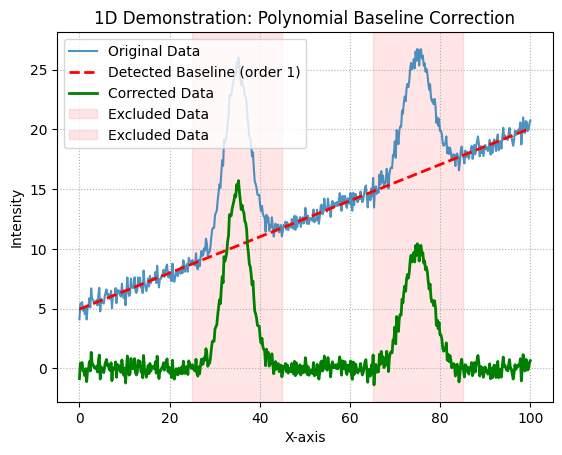

--- 1D Polynomial Demonstration Complete ---



In [3]:
def demo_polynomial_1d():
    """Demonstrates polynomial baseline correction by excluding signal regions."""
    print("--- Running 1D Polynomial Demonstration ---")
    x_data, y_data = generate_poly_1d_data()
    
    # Define the regions containing signals to exclude them from the baseline fit.
    exclude_signal_regions = [(25, 45), (65, 85)]
    print(f"Excluding signal regions {exclude_signal_regions} from the fit.")
    
    y_corrected, baseline = baseline_polynomial(
        y_data, x_data,
        poly_order=1, # Expecting a linear baseline
        exclude_regions=exclude_signal_regions
    )
    
    plt.figure()
    plt.plot(x_data, y_data, label='Original Data', alpha=0.8)
    plt.plot(x_data, baseline, 'r--', label='Detected Baseline (order 1)', linewidth=2)
    plt.plot(x_data, y_corrected, 'g', label='Corrected Data', linewidth=2)
    for start, end in exclude_signal_regions:
        plt.axvspan(start, end, color='red', alpha=0.1, label='Excluded Data')
        
    plt.title('1D Demonstration: Polynomial Baseline Correction')
    plt.xlabel('X-axis')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.show()
    print("--- 1D Polynomial Demonstration Complete ---\n")
demo_polynomial_1d()

### `demo_constant_offset()`

*   **Objective:** To illustrate the simplest baseline correction: subtracting a constant DC offset.
*   **Key Feature Showcased:** The use of the `offset_region_indices` parameter. A specific slice of the array (defined by start and end indices) is selected to calculate the average offset. This is a common technique when a portion of the data is known to contain only the baseline.
*   **Visualization:** The plot shows the original signal floating above the x-axis, the flat red line representing the calculated mean offset, and the corrected signal nicely centered around zero.

--- Running Constant Offset Demonstration ---
Calculating offset from index region (400, 500) using the 'mean' method.


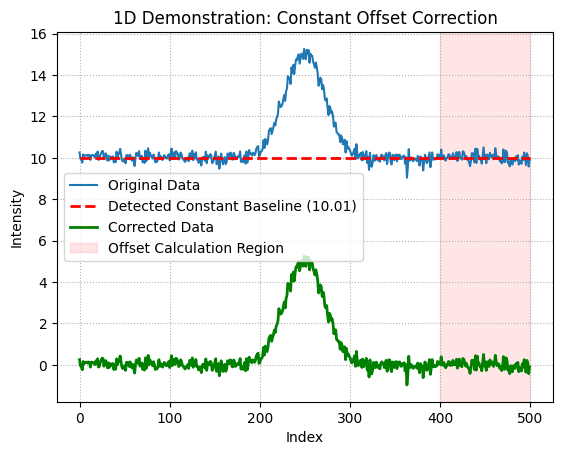

--- Constant Offset Demonstration Complete ---



In [4]:
def demo_constant_offset():
    """Demonstrates subtracting a constant offset calculated from a signal-free region."""
    print("--- Running Constant Offset Demonstration ---")
    y_data = generate_constant_offset_data()
    
    # Define a region where only baseline and noise exist (e.g., the end of the signal)
    # Using indices for this function.
    offset_region = (400, 500)
    print(f"Calculating offset from index region {offset_region} using the 'mean' method.")
    
    y_corrected, baseline = baseline_constant_offset(
        y_data,
        offset_region_indices=offset_region,
        method='mean'
    )

    plt.figure()
    plt.plot(y_data, label='Original Data')
    plt.plot(baseline, 'r--', label=f'Detected Constant Baseline ({baseline[0]:.2f})', linewidth=2)
    plt.plot(y_corrected, 'g', label='Corrected Data', linewidth=2)
    plt.axvspan(offset_region[0], offset_region[1], color='red', alpha=0.1, label='Offset Calculation Region')

    plt.title('1D Demonstration: Constant Offset Correction')
    plt.xlabel('Index')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.show()
    print("--- Constant Offset Demonstration Complete ---\n")
demo_constant_offset()

### `demo_mono_exponential()`

*   **Objective:** To correct a signal that lies on top of a classic mono-exponential decay curve. This is common in relaxation or decay-type measurements.
*   **Key Feature Showcased:** The ability of the non-linear fitter to find the parameters of an exponential decay (`y₀`, Amplitude, `τ`). It also demonstrates that the `exclude_regions` parameter is crucial for preventing the signal peak from corrupting the exponential fit.
*   **Visualization:** The plot shows the original decaying signal with a peak. The fitted red dashed line is a smooth exponential curve that accurately models the decay while ignoring the peak. The final corrected data shows the isolated peak on a flat baseline. The fitted parameters are printed to the console.

--- Running 1D Mono-Exponential Demonstration ---
Fitting mono-exponential decay while excluding region [(40, 60)].
Fit parameters found:
  - y0: 1.9250
  - A: 20.0549
  - tau: 40.4128
  - std_y0: 0.0666
  - std_A: 0.0559
  - std_tau: 0.3950


/Users/sylvainbertaina/Documents/Cloud_CNRS/GitHub/epyrtest/epyr/baseline/_1d.py:131: UserWarning: Using heuristic initial guess for _mono_exponential_decay_model ([y0, A, tau]): [np.float64(3.589959220154527), np.float64(18.532370555887592), np.float64(33.333333333333336)]
  warnings.warn(


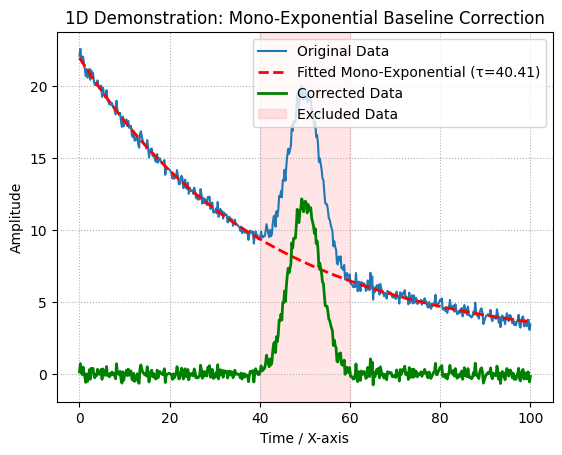

--- 1D Mono-Exponential Demonstration Complete ---



In [5]:
def demo_mono_exponential():
    """Demonstrates fitting and subtracting a mono-exponential decay."""
    print("--- Running 1D Mono-Exponential Demonstration ---")
    x_data, y_data = generate_exp_1d_data(stretched=False)
    
    # Exclude the peak so the fit is performed only on the baseline
    exclude_peak_region = [(40, 60)]
    print(f"Fitting mono-exponential decay while excluding region {exclude_peak_region}.")
    
    y_corrected, baseline, fit_params = baseline_mono_exponential(
        y_data, x_data,
        exclude_regions=exclude_peak_region
    )
    
    print("Fit parameters found:")
    for key, value in fit_params.items():
        print(f"  - {key}: {value:.4f}")
        
    plt.figure()
    plt.plot(x_data, y_data, label='Original Data')
    plt.plot(x_data, baseline, 'r--', label=f'Fitted Mono-Exponential (τ={fit_params["tau"]:.2f})', linewidth=2)
    plt.plot(x_data, y_corrected, 'g', label='Corrected Data', linewidth=2)
    plt.axvspan(exclude_peak_region[0][0], exclude_peak_region[0][1], color='red', alpha=0.1,label='Excluded Data')

    plt.title('1D Demonstration: Mono-Exponential Baseline Correction')
    plt.xlabel('Time / X-axis')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.show()
    print("--- 1D Mono-Exponential Demonstration Complete ---\n")
demo_mono_exponential()

### `demo_stretched_exponential()`

*   **Objective:** To handle more complex decay phenomena that do not follow a simple exponential curve, using the stretched exponential model.
*   **Key Feature Showcased:** The power of the stretched exponential model (`exp(-(t/τ)^β)`), which can describe a wider range of decay behaviors. The `beta` parameter, which is determined by the fit, characterizes the nature of the decay.
*   **Visualization:** The output is similar to the mono-exponential demo, but the fitted baseline curve has a slightly different shape dictated by the `beta` parameter. This demonstrates the function's ability to adapt to more complex baseline shapes.

--- Running 1D Stretched Exponential Demonstration ---
Fitting stretched exponential decay while excluding region [(40, 60)].
Fit parameters found:
  - y0: 2.0273
  - A: 19.8909
  - tau: 40.1418
  - beta: 2.2127
  - std_y0: 0.0300
  - std_A: 0.0580
  - std_tau: 0.1256
  - std_beta: 0.0192


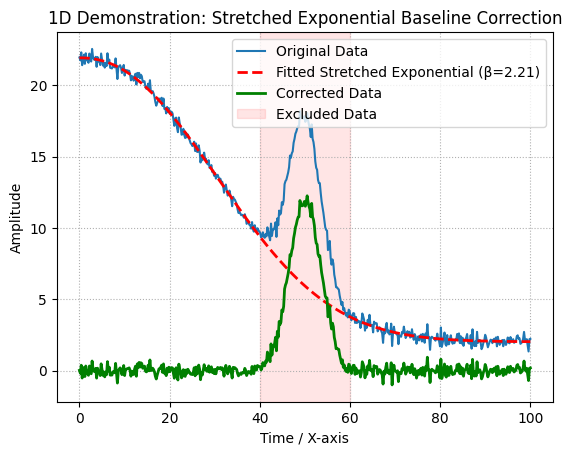

--- 1D Stretched Exponential Demonstration Complete ---



In [6]:
def demo_stretched_exponential():
    """Demonstrates fitting and subtracting a stretched exponential decay."""
    print("--- Running 1D Stretched Exponential Demonstration ---")
    x_data, y_data = generate_exp_1d_data(stretched=True)
    
    exclude_peak_region = [(40, 60)]
    print(f"Fitting stretched exponential decay while excluding region {exclude_peak_region}.")

    y_corrected, baseline, fit_params = baseline_stretched_exponential(
        y_data, x_data,
        exclude_regions=exclude_peak_region,
        initial_guess=[10,10,1,1]
    )
    
    print("Fit parameters found:")
    for key, value in fit_params.items():
        print(f"  - {key}: {value:.4f}")

    plt.figure()
    plt.plot(x_data, y_data, label='Original Data')
    plt.plot(x_data, baseline, 'r--', label=f'Fitted Stretched Exponential (β={fit_params["beta"]:.2f})', linewidth=2)
    plt.plot(x_data, y_corrected, 'g', label='Corrected Data', linewidth=2)
    plt.axvspan(exclude_peak_region[0][0], exclude_peak_region[0][1], color='red', alpha=0.1,label='Excluded Data')

    plt.title('1D Demonstration: Stretched Exponential Baseline Correction')
    plt.xlabel('Time / X-axis')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.show()
    print("--- 1D Stretched Exponential Demonstration Complete ---\n")

demo_stretched_exponential()


### `demo_polynomial_2d()`

*   **Objective:** To showcase baseline correction on 2D data, such as flattening an image or a spectral map that has a tilted or curved background.
*   **Key Feature Showcased:** The use of `exclude_regions` with 2D rectangular coordinates `((x_start, x_end), (y_start, y_end))`. It also shows how `poly_order=(1, 1)` is used to fit a tilted plane.
*   **Visualization:** This is a multi-panel plot for clear comparison:
    1.  **Original 2D Data:** Shows the peaks on a visibly tilted background.
    2.  **Detected Baseline Surface:** Displays the smooth, planar surface that was fitted to the data in the non-excluded regions.
    3.  **Corrected Data:** Shows the final result—a flat background with the two signal peaks clearly visible and preserved.

--- Running 2D Polynomial Surface Demonstration ---
Excluding rectangular regions to fit the baseline surface.


/var/folders/8q/tzzn2_ns7tg6gykc32v4h1g00000gn/T/ipykernel_68349/321392327.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


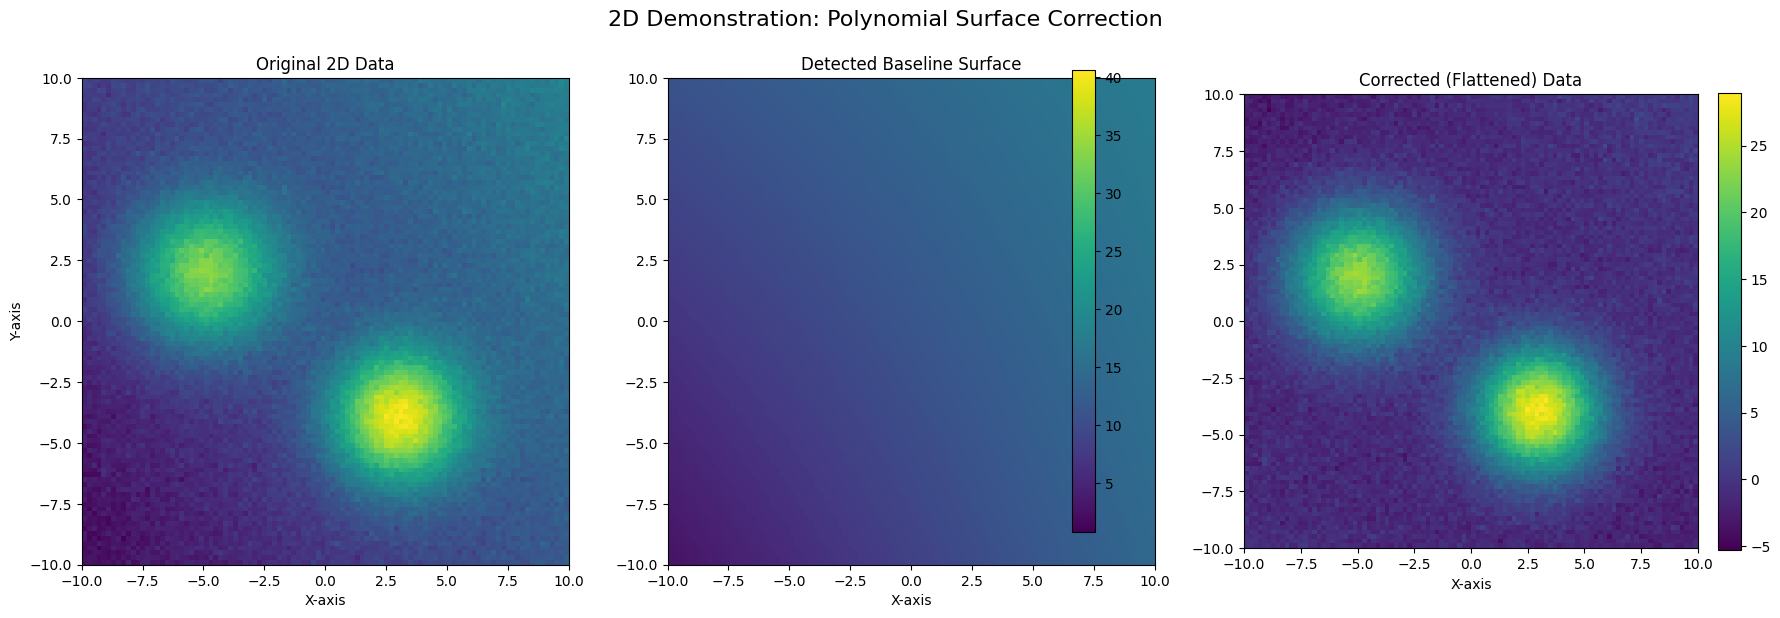

--- 2D Polynomial Surface Demonstration Complete ---



In [7]:
def demo_polynomial_2d():
    """Demonstrates 2D polynomial surface correction."""
    print("--- Running 2D Polynomial Surface Demonstration ---")
    x_coords, y_coords, z_data = generate_poly_2d_data()
    
    # Define rectangular regions containing peaks to exclude from the surface fit.
    exclude_rectangles = [
        ((0, 6), (-7, -1)),      # Bounding box for peak 1
        ((-8, -2), (-1, 5)),     # Bounding box for peak 2
    ]
    print("Excluding rectangular regions to fit the baseline surface.")
    
    z_corrected, baseline_surface = baseline_polynomial_2d(
        z_data, x_data=x_coords, y_data=y_coords,
        poly_order=(1, 1), # A tilted plane is order 1 in x and 1 in y
        exclude_regions=exclude_rectangles
    )
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    vmin, vmax = np.min(z_data), np.max(z_data)
    
    # 1. Original Data
    im1 = axes[0].imshow(z_data, origin='lower', extent=(x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]), vmin=vmin, vmax=vmax, cmap='viridis')
    axes[0].set_title('Original 2D Data')
    axes[0].set_xlabel('X-axis'); axes[0].set_ylabel('Y-axis')
    
    # 2. Detected Baseline Surface
    im2 = axes[1].imshow(baseline_surface, origin='lower', extent=(x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]), vmin=vmin, vmax=vmax, cmap='viridis')
    axes[1].set_title('Detected Baseline Surface')
    axes[1].set_xlabel('X-axis')
    
    # 3. Corrected Data
    im3 = axes[2].imshow(z_corrected, origin='lower', extent=(x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]), cmap='viridis')
    axes[2].set_title('Corrected (Flattened) Data')
    axes[2].set_xlabel('X-axis')

    fig.colorbar(im1, ax=axes[0:2], orientation='vertical', fraction=0.046, pad=0.04)
    fig.colorbar(im3, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)
    plt.suptitle('2D Demonstration: Polynomial Surface Correction', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    print("--- 2D Polynomial Surface Demonstration Complete ---\n")


demo_polynomial_2d()